# Explaining RL Decisions with Trajectories

This file contains code used for generating results of the gridworld experiments.

In [1]:
# Regular data science libraries
import numpy as np
import pandas as pd
import json
import os
import pickle
import random


# DNN libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# Import utility functions from other files
from utils import generate_model, dp, generate_offline_data
from env import Agent, Environment


# Plotting libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('ieee')


# Clustering libraries
from sklearn.decomposition import PCA
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES
from scipy.stats import wasserstein_distance

# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)


### Instantiate the Environment

Pick one of the three provided environments: FourRooms, 7x7 (default), or 5x5. The environment implementation is provided in a script attached with this notebook.

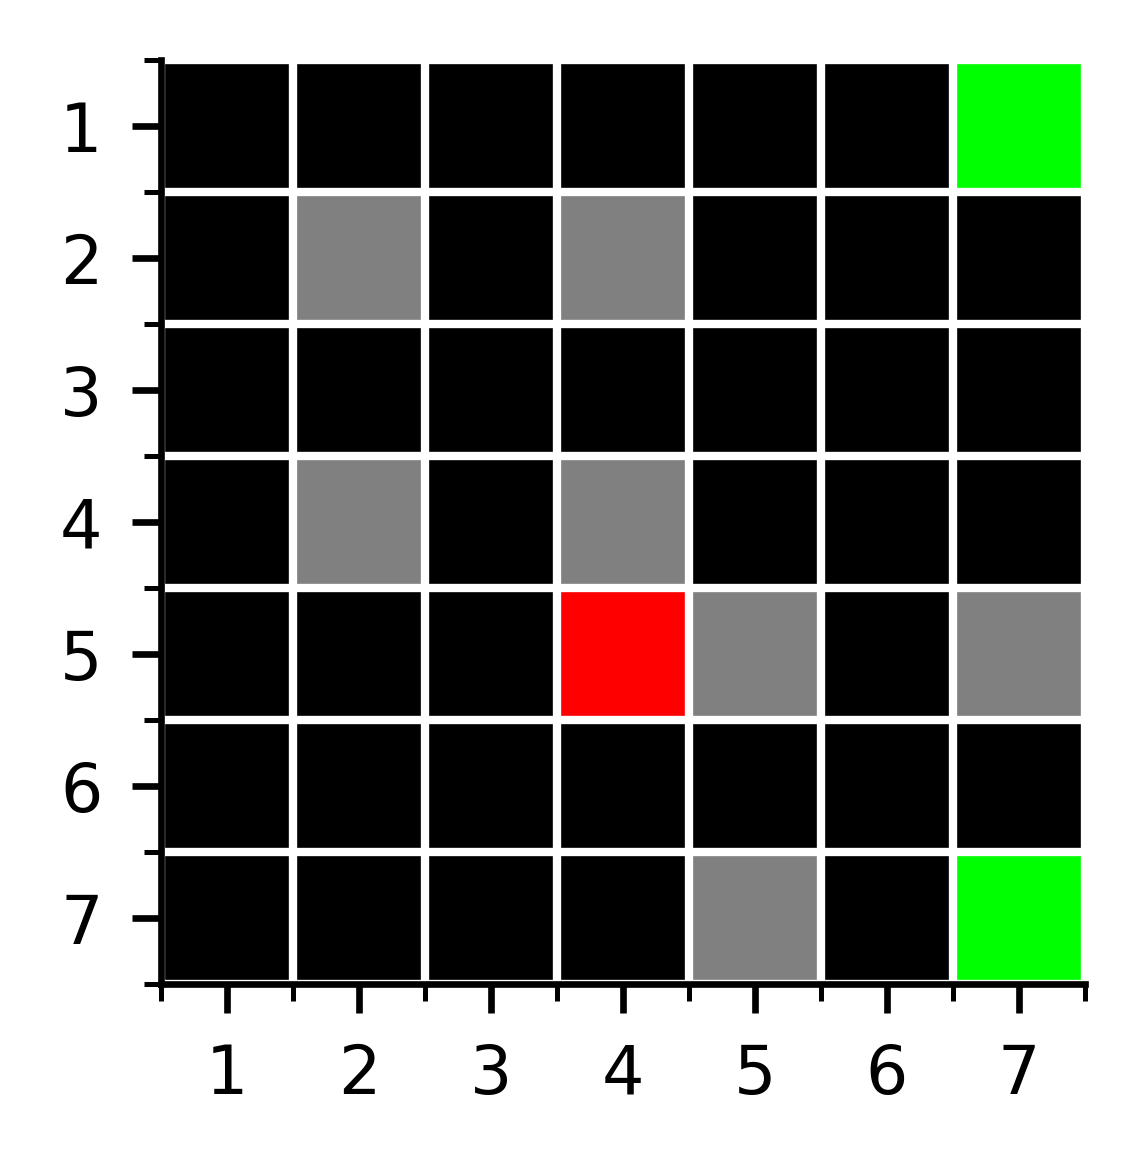

In [2]:
# # 7x7 Gridworld Environment

action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
reward_dict = {1:0, -1:1, -0.1:2, 0:3}

#####

# Environment Definition
env_width = 7
env_height = 7
env = Environment(dim=(env_width, env_height),
                  starts=[(2, 0), (6, 2), (2,4)],
                  terminals={(0, 6): +1, (6, 6): +1, (4, 3): -1},
                  obstacles=[[1, 1], [1, 3], [3, 1], [3, 3], [4,4], [6, 4], [4,6]],
                  stoc=0.)

env.render(title='7x7 Gridworld')

# Initialize the agent
agent = Agent(env)

#####

### Collecting offline trajectory data

In [3]:
# Generate offline data for the training
num_episodes_dyna = 2
num_agents_dyna = 20
max_traj_len = 20
num_pos_trajs = 500
num_neg_trajs = 100
offline_data = generate_offline_data(env, agent, num_episodes_dyna, num_agents_dyna, max_traj_len, num_pos_trajs, num_neg_trajs)

#####

Training 20 Agents


100%|██████████| 20/20 [00:00<00:00, 40.24it/s]


# POS TRAJs 1
# NEG TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# NEG TRAJs 2
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# NEG TRAJs 3
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# NEG TRAJs 4
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# NEG TRAJs 5
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# NEG TRAJs 6
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# NEG TRAJs 7
# NEG TRAJs 8
# POS TRAJs 43
# NEG TRAJs 9
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# NEG TRAJs 10
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
# POS TRAJs 51
# POS TRAJs 52
# NEG TRAJs 11
# POS TRAJs 53
# NEG TRAJs 12
# POS TRAJs 54
# POS TRAJs 55
# POS TRAJs 5

In [4]:
offline_data[:2]

[[(18, 2, -0.1, 19),
  (19, 2, -0.1, 20),
  (20, 1, -0.1, 13),
  (13, 1, 1.0, 6),
  (6, 0, 0, 6)],
 [(18, 1, -0.1, 11),
  (11, 1, -0.1, 4),
  (4, 2, -0.1, 5),
  (5, 2, 1.0, 6),
  (6, 0, 0, 6)]]

In [5]:
## If you are planning to pickle these trajectories and use them instead of generating them every time...
# results_save_dir = './gridworld_results/grid_7by7/'
# with open(os.path.join(results_save_dir, 'offline_traj.pkl'), 'wb') as f:
#     pickle.dump(offline_data, f)

# with open(os.path.join(results_save_dir, 'offline_traj.pkl'), 'rb') as f:
#     offline_data = pickle.load(f)

In [6]:
# Plot a trajectory to check if the data has been correctly formed
# env.plot_traj(offline_data[-1])

## Sequential Encoder

We use sequential encoder to parse the offline data and create clusters of the trajectories which will be used for attributing the decisions in the later steps.

## Training AE to encode trajectories

In [7]:
# def compute_traveled_vectors(trajectories):
#     """
#     Computes the vectors traveled for a list of trajectories.

#     Args:
#     - trajectories: A list of trajectories, each trajectory is a list of states,
#       and each state is represented by coordinates (i, j).

#     Returns:
#     - A list of vectors representing the movement from the start to the end of each trajectory.
#       Each vector is represented as (delta_i, delta_j).
#     """
#     traveled_vectors = []

#     for traj in trajectories:
#         if not traj:  # Check if the trajectory is empty
#             continue
#         for vector in traj:
#             traveled_vectors.append([vector[0], vector[1]])

# #         # Extract start and end points
# #         start_point = traj[0]  # First state's coordinates
# #         end_point = traj[-1]  # Last state's coordinates

# #         # Compute the traveled vector
# #         vector = (end_point[0] - start_point[0], end_point[1] - start_point[1])
        

#     return traveled_vectors

# traveled_vectors = compute_traveled_vectors(offline_data)
# traveled_vectors_tensor = torch.tensor(traveled_vectors, dtype=torch.float32)

# # Initialize an empty list to store rewards
# rewards = []

# # Iterate through each vector in traveled_vectors_tensor to assign rewards
# for vec in traveled_vectors_tensor:
#     if vec.tolist() == [18, 2]:  # Check if the vector matches the condition
#         rewards.append(1)
#     else:
#         rewards.append(-1)

# # Convert the list of rewards into a tensor
# rewards_tensor = torch.tensor(rewards, dtype=torch.float32).view(-1, 1)

# # Concatenate traveled_vectors with rewards for each entry
# data_with_rewards = torch.cat((traveled_vectors_tensor, rewards_tensor), dim=1)


# class TrajectoryDataset(Dataset):
#     def __init__(self, data):
#         self.data = data
    
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         # Return the entire data entry (including the reward) as both input and target
#         return self.data[idx], self.data[idx]  # (input, target)


In [25]:
from torch.utils.data import Dataset
import random

class DualDataset(Dataset):
    def __init__(self, features):
        # Flatten the input list of lists of tuples into a list of tuples (first and third values)
        self.features = [(f[0], f[2]) for feature_list in features for f in feature_list]
        # Extract rewards (second value of each tuple) for the entire dataset
        self.rewards = [f[1] for feature_list in features for f in feature_list]
        
        # Create a dictionary to group indices by rewards for positive/negative sampling
        self.indices_dict = {}
        for idx, reward in enumerate(self.rewards):
            if reward not in self.indices_dict:
                self.indices_dict[reward] = []
            self.indices_dict[reward].append(idx)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        # Get the anchor data and its reward
        anchor_data = self.features[index]
        anchor_reward = self.rewards[index]

        # Select a positive sample (same reward but different index)
        pos_indices = [idx for idx in self.indices_dict[anchor_reward] if idx != index]
        pos_idx = random.choice(pos_indices)
        positive_data = self.features[pos_idx]

        # Select a negative sample (different reward)
        neg_rewards = list(self.indices_dict.keys() - {anchor_reward})
        neg_reward = random.choice(neg_rewards)
        neg_idx = random.choice(self.indices_dict[neg_reward])
        negative_data = self.features[neg_idx]

        return anchor_data, positive_data, negative_data

    
dual_dataset = DualDataset(offline_data)
embedding_loader = DataLoader(dual_dataset, batch_size=32, shuffle=True)

In [26]:
def contrastive_loss(anchor_emb, positive_emb, negative_emb, margin=0.5):
    """
    Compute the contrastive loss given batches of anchor, positive, and negative embeddings.
    
    Args:
    - anchor_emb: Tensor of anchor embeddings
    - positive_emb: Tensor of positive embeddings (similar to the anchor)
    - negative_emb: Tensor of negative embeddings (dissimilar to the anchor)
    - margin: Margin by which negative pairs should be separated
    
    Returns:
    - loss: Computed contrastive loss
    """
    # Positive pair similarity (smaller values mean more similar)
    pos_distance = F.pairwise_distance(anchor_emb, positive_emb, p=10)
    # Negative pair similarity
    neg_distance = F.pairwise_distance(anchor_emb, negative_emb, p=2)
    
    # Contrastive loss: Maximize the distance between negative pairs
    # and minimize the distance between positive pairs
    losses = F.relu(pos_distance - neg_distance + margin)
    
    return losses.mean()

class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(2, 2)  # Assuming the input data is flattened if necessary; reduces dimension from 3 to 2
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 2)  # Attempts to reconstruct the original 3-dimensional data from the 2D encoded form
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Create the autoencoder model
model = SimpleAutoencoder()


In [28]:
# Define the model, optimizer, and contrastive loss function as described previously
num_epochs = 25
model = SimpleAutoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    total_loss = 0
    # Assuming you have a way to get anchor, positive, and negative samples
    for anchor, positive, negative in embedding_loader:  # data_loader to provide (anchor, positive, negative)
        print(f'anchor: {anchor} positive:  {positive}')
        optimizer.zero_grad()
        
        # Forward pass to get embeddings and reconstructions
        positive_emb = model(torch.tensor(positive))
        anchor_emb = model(torch.tensor(anchor))
        negative_emb = model(torch.tensor(negative))
        print(anchor_emb[0], positive_emb[0], negative_emb[0])
        # Compute contrastive loss
        cont_loss = contrastive_loss(anchor_emb, positive_emb, negative_emb, margin=1.0)
        
        # Optionally, compute reconstruction loss if you're using it
        # recon_loss = F.mse_loss(reconstructed_anchor, anchor)  # Example for anchor
        
        # Combine losses if using both, or just use contrastive loss
        loss = cont_loss  # Or, e.g., loss = recon_loss + cont_loss
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Print average loss for the epoch
    print(f'Epoch: {epoch + 1}, Avg Loss: {total_loss / len(triplet_loader)}')

anchor: [tensor([18,  6,  4, 18,  4, 17,  6, 20, 29, 39, 14, 18,  9, 20, 20, 11,  7, 19,
        39, 20,  5, 20,  4,  0, 20,  6,  6,  4,  6, 11, 20,  5]), tensor([-0.1000,  0.0000, -0.1000, -0.1000, -0.1000, -0.1000,  0.0000, -0.1000,
        -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
        -0.1000, -0.1000, -0.1000, -0.1000,  1.0000, -0.1000, -0.1000, -0.1000,
        -0.1000,  0.0000,  0.0000, -0.1000,  0.0000, -0.1000, -0.1000,  1.0000],
       dtype=torch.float64)] positive:  [tensor([ 6, 19, 30, 18, 18, 37, 25, 18, 18, 11, 48,  0, 18, 19, 19,  6, 19,  4,
        20, 20,  5, 30, 19, 20, 17,  9, 20, 38,  4, 39,  6, 29]), tensor([ 0.0000, -0.1000, -1.0000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
        -0.1000, -0.1000,  0.0000, -0.1000, -0.1000, -0.1000, -0.1000,  0.0000,
        -0.1000, -0.1000, -0.1000, -0.1000,  1.0000, -1.0000, -0.1000, -0.1000,
        -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,  0.0000, -0.1000],
       dtype=tor

ValueError: only one element tensors can be converted to Python scalars

In [24]:
# torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_5.pth')
# torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_fourrooms.pth')
torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_7.pth')

### Encode trajectories in the offline datasetdata_with_rewards

In [ ]:
len(data_with_rewards)

In [ ]:
# Assuming `data_with_rewards` is a tensor where the last column is the reward
# and `model` is your autoencoder model with an accessible encoder module.

# Initialize a list to hold trajectory embeddings
traj_embeddings = []

# Iterate over the data to process each trajectory
for traj in data_with_rewards:
    with torch.no_grad():
        # Exclude the reward from the input to the autoencoder
        input_data = traj.unsqueeze(0)  # Add batch dimension

        # Encode the trajectory to get its embedding
        # Here, we directly access the encoder part of the autoencoder
        embedding = model.encoder(input_data)
        
        # Convert the tensor to numpy array and reshape
        # The `embedding` tensor is already 2D (encoded), so we might not need to reshape it
        embedding_np = embedding.numpy().reshape(-1)
        
        # Append the embedding to the list
        traj_embeddings.append(embedding_np)


In [ ]:
traj_embeddings[:2]

### PCA analysis of the trajectory embeddings

In [ ]:
traj_embeddings_np = np.array(traj_embeddings)

# Create a DataFrame for plotting
plotting_data = {
    'feature 1': traj_embeddings_np[:, 0],
    'feature 2': traj_embeddings_np[:, 1],
    'rewards': rewards
}
df = pd.DataFrame(plotting_data)

# Plotting
plt.figure(figsize=(4, 3))
sns.scatterplot(x='feature 1', y='feature 2', hue='rewards', palette={-1: "r", 1: "g"}, data=df)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Reward', loc='best')
plt.tight_layout()
plt.show()

### Clustering of the trajectories using X-Means

In [ ]:
traveled_vectors = []
len(
for traj in offline_data:
    # Extract start and end points
    reward = 1 if  (traj[-1][:2] == [18, 2]) else -1

    # Convert start and end points to tensors, include the reward, and add a batch dimension
    start_point = torch.tensor([[traj[0][0], traj[0][1], -1]], dtype=torch.float32)
    end_point = torch.tensor([[traj[-1][0], traj[-1][1], reward]], dtype=torch.float32)
    print(f'end_point: {end_point}')
    # Pass the tensors through the encoder
    # Assuming model.encoder() can handle the additional reward dimension; adjust if necessary
    start_point_encoded = model.encoder(start_point)
    end_point_encoded = model.encoder(end_point)


    # Calculate the traveled vector
    vector = (end_point_encoded - start_point_encoded).squeeze().tolist()
    print(f'vector: {vector}, reward: {reward}')
    traveled_vectors.append(vector)

In [ ]:
plotting_data = {
    'Delta i': [vec[0] for vec in traveled_vectors],
    'Delta j': [vec[1] for vec in traveled_vectors],
    'Rewards': [+1] * num_pos_trajs + [-1] * num_neg_trajs
}

df = pd.DataFrame(plotting_data)

# Plot
plt.figure(figsize=(4, 3))
sns.scatterplot(x='Delta i', y='Delta j', hue='Rewards', data=df, palette=['red', 'blue'], style='Rewards', markers=['o', 'X'])
plt.xlabel('Feature 1 (Delta i)')
plt.ylabel('Feature 2 (Delta j)')
# plt.title('Traveled Vectors with Rewards')
plt.legend(title='Reward')
plt.grid(True)  # Optional: Adds grid for better readability
plt.show()

In [ ]:
rewards =  [+1] * num_pos_trajs + [-1] * num_neg_trajs
plt.figure(figsize=(6, 6))
for vector, reward in zip(traveled_vectors, rewards):
    # Determine color based on reward
    color = 'blue' if reward == +1 else 'red'
    
    # Draw the vector as an arrow
    plt.arrow(0, 0, vector[0], vector[1], head_width=0.1, head_length=0.1, fc=color, ec=color)

# Setting the plot limits
plt.xlim(min([v[0] for v in traveled_vectors]) - 1, max([v[0] for v in traveled_vectors]) + 1)
plt.ylim(min([v[1] for v in traveled_vectors]) - 1, max([v[1] for v in traveled_vectors]) + 1)

plt.xlabel('Delta i')
plt.ylabel('Delta j')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(True)
plt.title('Traveled Vectors with Rewards')
plt.show()

In [ ]:

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(traveled_vectors, amount_initial_centers).initialize()
 
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 10.
xmeans_instance = xmeans(traveled_vectors, initial_centers, 10)
xmeans_instance.process()
 
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
 
# Print total sum of metric errors
# print("Total WCE:", xmeans_instance.get_total_wce())
# print("Clusters:", clusters)
# print('Number of clusters', len(clusters))

In [ ]:
# Assuming 'clusters' is a list of clusters, each containing indices of trajectories in 'offline_data'
selected_clusters_indices = [0,1,2,3]  # Example selection of clusters for comparison

# Initialize a list to hold collected trajectories and starting points for each cluster
collected_clusters_trajectories = []
collected_clusters_starts = []

for cluster_index in selected_clusters_indices:
    collected_trajectories = []
    start_points = np.zeros(shape=env.dim)  # Assuming env.dim gives the dimension of the grid

    for trajectory_idx in clusters[cluster_index]:
        selected_trajectory = offline_data[trajectory_idx]
        collected_trajectories.append(selected_trajectory)
        
        # Assuming each trajectory[0] is the starting state and you can convert it to grid coordinates
        start_state = selected_trajectory[0][0]  # [0] for the first state-action-reward tuple, [0] for the state
        start_i, start_j = env.idx_to_coords(start_state)  # Convert start state to coordinates
        start_points[start_i, start_j] += 1  # Increment start point count

    collected_clusters_trajectories.append(collected_trajectories)
    collected_clusters_starts.append(start_points)

env.plot_traj_densities_with_starts(collected_clusters_trajectories, collected_clusters_starts)

In [ ]:
def plot_traveled_vectors_from_start_points(start_points, traveled_vectors, rewards):
    """
    Plots traveled vectors as directed lines from their start points, with start points represented as dots,
    and colors indicating the reward. Sets the y-axis limit to (-1, 6).
    
    Args:
    - start_points: A list of (start_i, start_j) tuples representing the start points.
    - traveled_vectors: A list of (delta_i, delta_j) tuples representing the vectors.
    - rewards: A list of rewards corresponding to each vector, where +1 is blue and -1 is red.
    """
    plt.figure(figsize=(6, 3))
    for start_point, vector, reward in zip(start_points, traveled_vectors, rewards):
        color = 'blue' if reward == 1 else 'red'  # Color based on reward
        start_i, start_j = start_point  # Start coordinates
        end_i, end_j = start_i + vector[0], start_j + vector[1]  # End coordinates based on vector
        # Plot the vector as an arrow
        plt.arrow(start_i, start_j, vector[0], vector[1], head_width=0.1, head_length=0.15, fc=color, ec=color)
        # Plot the start point as a dot
        plt.plot(start_i, start_j, 'o', color='black', markersize=3)
    
    # Setting axis labels and title
    plt.xlabel('i')
    plt.ylabel('j')
    plt.grid(True)
    plt.axis('equal')
    plt.title('Traveled Vectors from Start Points with Rewards')
    plt.ylim(-1, 15)
    plt.show()
    
def calculate_start_points_and_vectors(offline_data):
    """
    Calculates start points and traveled vectors from a list of trajectories.
    
    Args:
    - offline_data: A list of trajectories, each trajectory is a list of states,
      and each state is represented by coordinates (i, j).
    
    Returns:
    - start_points: A list of (i, j) tuples representing the start points of each trajectory.
    - traveled_vectors: A list of (delta_i, delta_j) tuples representing the traveled vector 
      from start to end of each trajectory.
    """
    start_points = []
    traveled_vectors = []

    for traj in offline_data:
        if not traj:  # Check if the trajectory is empty
            continue

        # Extract start and end points
        start_point = traj[0][:2]
        end_point = traj[-1][:2]

        # Calculate the traveled vector
        vector = (end_point[0] - start_point[0], end_point[1] - start_point[1])

        # Append to lists
        start_points.append(start_point)
        traveled_vectors.append(vector)

    return start_points, traveled_vectors

start_points, traveled_vectors = calculate_start_points_and_vectors(offline_data)
plot_traveled_vectors_from_start_points(start_points, traveled_vectors, rewards)

In [ ]:
# for cluster_id, cluster in enumerate(clusters):
#     print('-'*10)
#     print('Cluster ID', cluster_id)
#     for traj_id in cluster:
#         env.plot_traj(offline_data[traj_id])    
#     print('-'*10)

In [ ]:
traj_cluster_labels = np.zeros(len(traj_embeddings), dtype=int)

for cluster_id, cluster in enumerate(clusters):
    for traj_id in cluster:
        traj_cluster_labels[traj_id] = cluster_id


In [ ]:
palette = sns.color_palette('husl', len(clusters) + 1)
palette

In [ ]:
# cluster_data_embeds = [result_data_combinations[cid][1] for cid in result_data_combinations]
# cluster_data_embeds.pop(0)

pca_traj = PCA(n_components=2)
pca_traj_embeds = pca_traj.fit_transform(traj_embeddings)
plotting_data = {'feature 1': pca_traj_embeds[:, 0],
                 'feature 2': pca_traj_embeds[:, 1],
                 'cluster id': traj_cluster_labels}
df = pd.DataFrame(plotting_data)

plt.figure(figsize=(4,3))
data_ax = sns.scatterplot(x='feature 1',
                          y='feature 2',
                          hue='cluster id',
                          palette=palette[:len(clusters)],
                          data=df,
                          legend=True)
plt.legend(title = '$c_{j}$', loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=5)
# plt.legend(title = '$c_{j}$', loc='center left', bbox_to_anchor=(1., 0.7), ncol=2)
# for cid, _ in enumerate(cluster_data_embeds):
#     data_ax.text(pca_data_embeds[:, 0][cid],
#                  pca_data_embeds[:, 1][cid],
#                  str(cid),
#                  horizontalalignment='left',
#                  size='medium',
#                  color='black',
#                  weight='semibold')
plt.tight_layout()
plt.savefig('./traj_clustering_grid.pdf')
plt.show()

## Encode sets of trajectories

In [ ]:
def get_data_embedding(traj_embeddings):
#     return np.exp(np.abs(np.array(traj_embeddings).sum(axis=0)/100.))/np.sum(np.abs(np.exp(np.array(traj_embeddings).sum(axis=0)/100.)))
    return np.exp(np.array(traj_embeddings).sum(axis=0)/10.)/np.sum(np.exp(np.array(traj_embeddings).sum(axis=0)/10.))

data_embedding = get_data_embedding(traj_embeddings)

### Train models on different cluster combinations

In [ ]:
transition_model, reward_model = generate_model(env, offline_data)
values, action_values, policy = dp(env, transition_model, reward_model, gamma=0.95, threshold=1e-4)

In [ ]:
result_data_combinations = {0:(action_values, data_embedding)}
cluster_embeddings = {}

for cluster_id, cluster in enumerate(clusters):
    temp_data = []
    temp_traj_embeds = []
    temp_cluster_traj_embeds = []
    for traj_id, traj in enumerate(offline_data):
        if traj_id not in cluster:
            temp_data.append(offline_data[traj_id])
            temp_traj_embeds.append(traj_embeddings[traj_id])
        else:
            temp_cluster_traj_embeds.append(traj_embeddings[traj_id])
            
    # Generate the data embedding
    data_embedding_new = get_data_embedding(temp_traj_embeds)
    
    # Generate cluster embedding
    cluster_embedding = get_data_embedding(temp_cluster_traj_embeds)
    
    # Train an agent on the new data
    transition_model_new, reward_model_new = generate_model(env, temp_data)
    values_new, action_values_new, policy_new = dp(env,
                                                   transition_model_new,
                                                   reward_model_new,
                                                   gamma=0.95,
                                                   threshold=1e-4)
    
    # Collect the data embedding and the trajectory
    result_data_combinations[cluster_id + 1] = (action_values_new, data_embedding_new)
    cluster_embeddings[cluster_id] = cluster_embedding

### Generate attributions

In [ ]:
attributions = []

for state in range(np.prod(env.dim)):
    
    if (state//env_width, state%env_width) in env.terminals:
        continue
        
    orig_state_action_values = action_values[state]
    orig_opt_state_actions = np.where(orig_state_action_values == np.max(orig_state_action_values))[0]

    distances = []
    new_actions = []
    for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items():
        new_state_action_values = action_values_new[state]
        new_opt_state_actions = np.where(new_state_action_values == np.max(new_state_action_values))[0]

        if list(new_opt_state_actions) != list(orig_opt_state_actions):
            w_d = wasserstein_distance(data_embedding, data_embedding_new)
        else:
            w_d = 1e9
        
        distances.append(w_d)
        new_actions.append(new_opt_state_actions)
    
    responsible_data_combination = np.argsort(distances)[0]
    
    if distances[responsible_data_combination] == 1e9 or distances[responsible_data_combination] == 0:
        continue
    
    print('-'*10)
    print(f'State - {state%env_width + 1, state//env_width + 1}')
    print(f'Distance - {distances[responsible_data_combination]}')
    print(f'Original Actions -{[action_dict[orig_action] for orig_action in orig_opt_state_actions]}')
    print(f'New Action - {[action_dict[new_action] for new_action in new_actions[responsible_data_combination]]}')

    print(f'Responsible data combination - data id {responsible_data_combination}')
    print(f'Responsible trajectory id {clusters[responsible_data_combination - 1]}')
    if len(clusters[responsible_data_combination - 1]):
        cid_list = list(range(len(clusters)))
        cid_list.pop(responsible_data_combination - 1)
        alternate_cid = np.random.choice(cid_list)
        attributions.append({
            'state' : (state%env_width + 1, state//env_width + 1),
            'orig_act': [action_dict[orig_action] for orig_action in orig_opt_state_actions],
            'new_act': [action_dict[new_action] for new_action in new_actions[responsible_data_combination]],
            'attributed_trajs':clusters[responsible_data_combination - 1],
            'random_baseline_trajs': list(np.random.randint(0, len(offline_data), 5)),
            'alternate_cluster_trajs': clusters[alternate_cid - 1],
            'responsible_cluster': responsible_data_combination - 1
        })
#         for traj in clusters[responsible_data_combination - 1]:
#             env.plot_traj(offline_data[traj])
    print('-'*10)

In [ ]:
attributions

In [ ]:
results_save_dir = './gridworld_results/grid_7by7/'
if not os.path.exists(results_save_dir):
    os.makedirs(results_save_dir)


# for traj_id, traj in enumerate(offline_data):
#     env.plot_traj(traj, path=os.path.join(results_save_dir, 'traj_' + str(traj_id) + '.png'))


In [ ]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [ ]:
# Data to save
data_to_be_saved = [
    {
        'attributions' : attributions,
    }
]

dumped = json.dumps(data_to_be_saved, cls=NumpyEncoder)

with open(os.path.join(results_save_dir, 'attribution_results.json'), 'w') as f:
    json.dump(dumped, f)

In [ ]:
attributions

## Initial State Value Estimates

In [ ]:
for data_combination_id in result_data_combinations:
    print(result_data_combinations[data_combination_id][0].max(axis=1).mean())

## Average delta q

In [ ]:
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    print(np.sum(np.abs(action_values_new - result_data_combinations[0][0]))/(env_width*env_height))

## Compare the actions

In [ ]:
action_comparison = {}
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    action_comparison[data_combination_id] = 0
    for i in range(env_width*env_height):
            orig_actions = np.where(result_data_combinations[0][0][i] == np.max(result_data_combinations[0][0][i]))[0]
            alternate_actions = np.where(result_data_combinations[data_combination_id][0][i] == np.max(result_data_combinations[data_combination_id][0][i]))[0]
            
            if list(orig_actions) == list(alternate_actions):
                action_comparison[data_combination_id] += 1 
#             alternate_actions = 
#     print(np.sum(np.argmax(action_values_new, axis=1) != np.argmax(result_data_combinations[0][0], axis=1))/(env_width*env_height))

In [ ]:
np.array(list(action_comparison.values()))/(env_width*env_height)

## Data distances

In [ ]:
data_distances = np.zeros(len(result_data_combinations))
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    data_distances[data_combination_id] = wasserstein_distance(data_embedding, data_embedding_new)

In [ ]:
with np.printoptions(precision=5, suppress=True):
    print((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))

## Cluster Attribution Frequency

In [ ]:
cluster_attr_freq = np.zeros(len(clusters))

In [ ]:
for attribution in attributions:
    cluster_attr_freq[attribution['responsible_cluster']] += 1 

In [ ]:
cluster_attr_freq/cluster_attr_freq.sum()